In [112]:
import numpy as np
import torch
import torchvision

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 

from torch.utils.data import DataLoader

In [113]:
NUM_EPOCHS = 1
LR = 1e-3
BATCH_SIZE = 64

In [114]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [115]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 1 * 1, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x

In [116]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [117]:
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0
print("Finished Training")

Epoch [1/1], Batch [100/938], Loss: 2.0262
Epoch [1/1], Batch [200/938], Loss: 1.6736
Epoch [1/1], Batch [300/938], Loss: 1.5540
Epoch [1/1], Batch [400/938], Loss: 1.5347
Epoch [1/1], Batch [500/938], Loss: 1.5230
Epoch [1/1], Batch [600/938], Loss: 1.5111
Epoch [1/1], Batch [700/938], Loss: 1.5078
Epoch [1/1], Batch [800/938], Loss: 1.5071
Epoch [1/1], Batch [900/938], Loss: 1.4969
Finished Training


In [118]:
# Testing the model
correct = 0
total = 0
predictions = np.zeros([10, 10])
counts = np.zeros([10])
results = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        
        confidences, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for pred, label, confidence in zip(predicted, labels, confidences):
            predictions[label, pred] += 1
            counts[label] += 1
            results.append((confidence, pred, label))
results = np.asarray(results)
print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")

Accuracy of the network on the 10000 test images: 96.58%


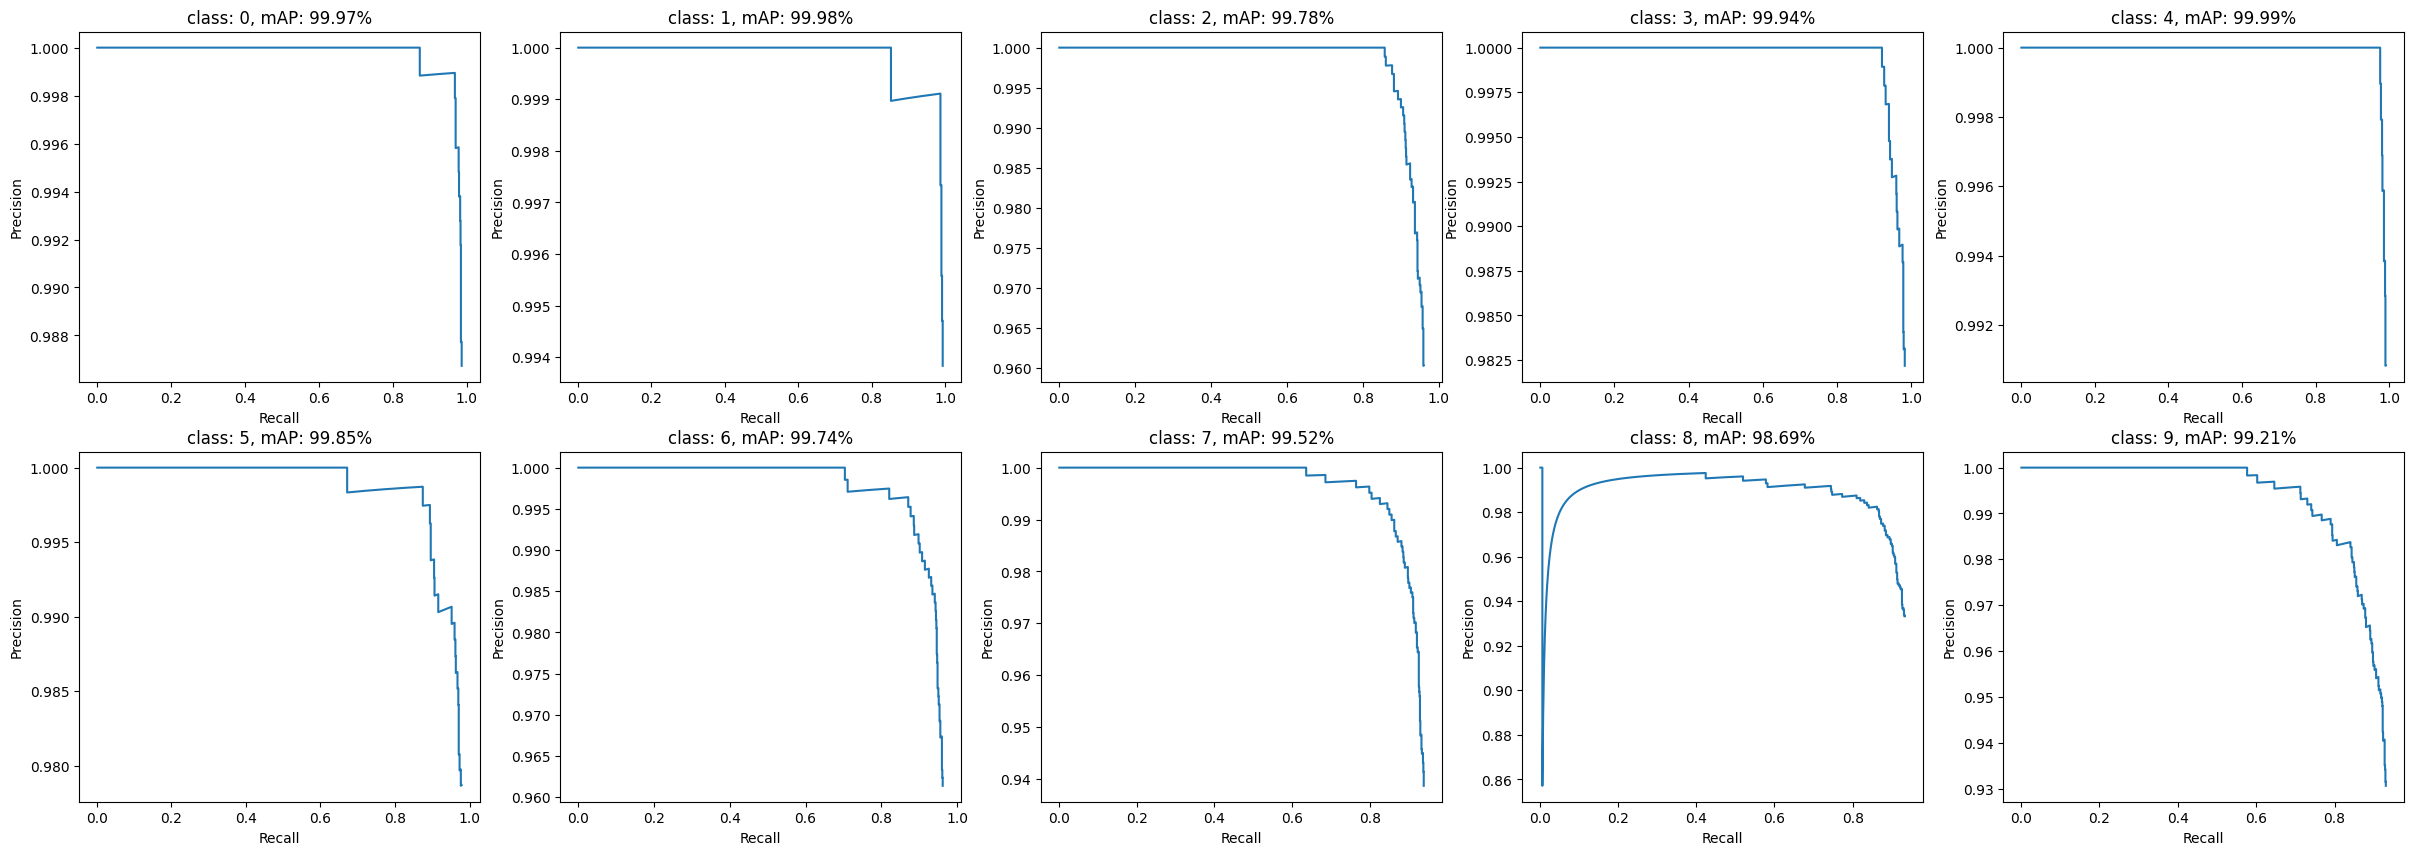

In [165]:
indices = np.argsort(results[:, 0])[::-1]
results = results[indices]

count = np.ones(10)
true_count = np.zeros(10)

precisions = [[] for _ in range(10)]
recalls = [[] for _ in range(10)]

segments = [[] for _ in range(10)]

for confidence, pred, label in results:
    label = int(label)
    pred = int(pred)
    
    true_count[label] += pred == label
    
    precision = true_count[label] / count[label]
    recall = true_count[label] / counts[label]
    
    segments[label].append(true_count[label])
    
    precisions[label].append(precision)
    recalls[label].append(recall)
    
    count[label] += 1
    
fig, axes = plt.subplots(2, 5, figsize=(30, 10))
for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        AP = np.asarray(precisions[idx])
        mAP = AP.mean()
        
        axes[i, j].plot(recalls[idx], AP)
        axes[i, j].set_title(f"class: {idx}, mAP: {mAP * 100:0.2f}%")
        axes[i, j].set_ylabel("Precision")
        axes[i, j].set_xlabel("Recall")
plt.show()